In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import HiveContext
from pyspark.ml.regression import LinearRegression

In [7]:
# Create a Spark session which is hive enabled
spark = SparkSession.builder \
.appName("ReadingFromHive") \
.master("local") \
.enableHiveSupport() \
.getOrCreate()

In [8]:
df = spark.sql("select * from lin_reg_ext where var_1 is not null")

In [9]:
df.show(5)

+-----+-----+-----+-----+-----+------+
|var_1|var_2|var_3|var_4|var_5|output|
+-----+-----+-----+-----+-----+------+
|  734|  688|   81|0.328|0.259| 0.418|
|  700|  600|   94| 0.32|0.247| 0.389|
|  712|  705|   93|0.311|0.247| 0.417|
|  734|  806|   69|0.315| 0.26| 0.415|
|  613|  759|   61|0.302| 0.24| 0.378|
+-----+-----+-----+-----+-----+------+
only showing top 5 rows



<Figure size 720x720 with 0 Axes>

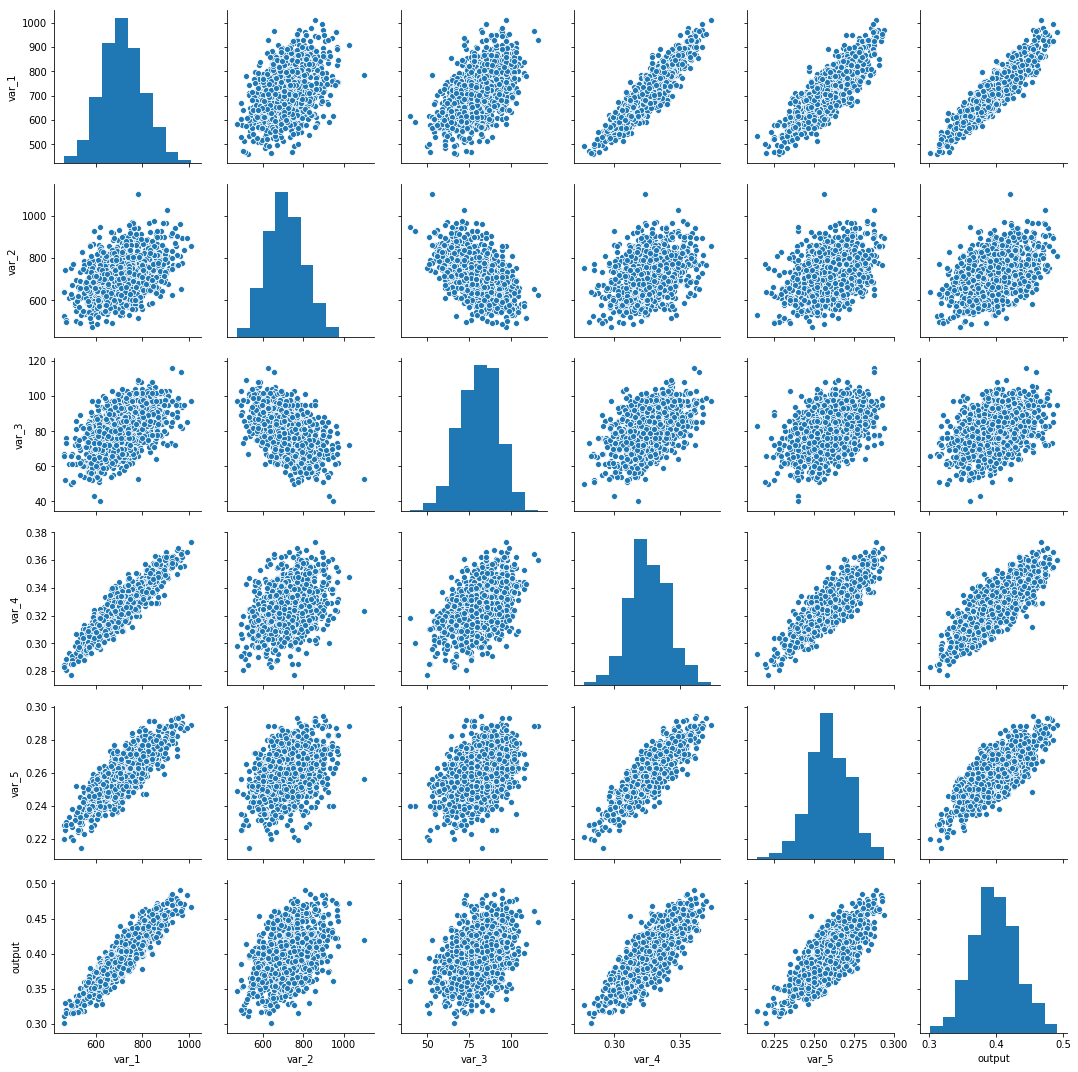

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

df_pd = df.toPandas()
plt.figure(figsize=(10,10))
sns.pairplot(data=df_pd)
plt.show()

In [11]:
df_pd.corr()

,var_1,var_2,var_3,var_4,var_5,output
var_1,1.000000,0.380139,0.511745,0.900492,0.827000,0.918740
var_2,0.380139,1.000000,-0.532394,0.326360,0.330764,0.436527
var_3,0.511745,-0.532394,1.000000,0.481836,0.408716,0.401496
var_4,0.900492,0.326360,0.481836,1.000000,0.851958,0.790910
var_5,0.827000,0.330764,0.408716,0.851958,1.000000,0.790481
output,0.918740,0.436527,0.401496,0.790910,0.790481,1.000000


In [12]:
print(df.count(),len(df.columns))

1232 6


In [13]:
df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: float (nullable = true)
 |-- var_5: float (nullable = true)
 |-- output: float (nullable = true)



In [14]:
df.describe().show(2,False)

+-------+-----------------+-----------------+-----------------+-------------------+-----------------+-------------------+
|summary|var_1            |var_2            |var_3            |var_4              |var_5            |output             |
+-------+-----------------+-----------------+-----------------+-------------------+-----------------+-------------------+
|count  |1232             |1232             |1232             |1232               |1232             |1232               |
|mean   |715.0819805194806|715.0819805194806|80.90422077922078|0.32633116848573285|0.259272727111427|0.39734172100177056|
+-------+-----------------+-----------------+-----------------+-------------------+-----------------+-------------------+
only showing top 2 rows



In [15]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [16]:
vec_assembler = VectorAssembler(inputCols=['var_1','var_2','var_3','var_4','var_5'],outputCol='features')

In [17]:
features_df = vec_assembler.transform(df)

In [18]:
features_df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: float (nullable = true)
 |-- var_5: float (nullable = true)
 |-- output: float (nullable = true)
 |-- features: vector (nullable = true)



In [19]:
model_df = features_df.select('features','output')

In [20]:
model_df.show(5)

+--------------------+------+
|            features|output|
+--------------------+------+
|[734.0,688.0,81.0...| 0.418|
|[700.0,600.0,94.0...| 0.389|
|[712.0,705.0,93.0...| 0.417|
|[734.0,806.0,69.0...| 0.415|
|[613.0,759.0,61.0...| 0.378|
+--------------------+------+
only showing top 5 rows



In [21]:
print(model_df.count(),len(model_df.columns))

1232 2


In [22]:
train_df,test_df = model_df.randomSplit([0.7,0.3])

In [23]:
print(train_df.count(),len(train_df.columns))

872 2


In [24]:
print(test_df.count(),len(test_df.columns))

360 2


In [25]:
lin_reg = LinearRegression(labelCol='output')

In [26]:
lr_model = lin_reg.fit(train_df)

In [27]:
lr_model.intercept

0.184681480446175

In [28]:
print(lr_model.coefficients)

[0.00034238783680000845,5.2719210197929105e-05,0.00019401416027405263,-0.6632932174489675,0.5052729691330758]


In [29]:
training_prediction = lr_model.evaluate(train_df)

In [30]:
training_prediction.r2

0.8717196864301014

In [31]:
training_prediction.meanSquaredError

0.00014310031862435494

In [32]:
test_result = lr_model.evaluate(test_df)

In [33]:
test_result.residuals.show(10)

+--------------------+
|           residuals|
+--------------------+
|-0.00149826418408...|
|-0.01030990448365...|
| 0.00192405542348989|
|-0.00874524762345...|
|0.007467175808648363|
|-0.00612749082301...|
|-8.63113144403737...|
|0.008529135825149525|
|0.004929119863967...|
| 0.01166155193706786|
+--------------------+
only showing top 10 rows



In [34]:
test_result.r2

0.8626518062042166

In [35]:
test_result.meanSquaredError

0.00014832359185768342